## Lab 2: ChemBL Multi-Task Model

Team: Mike Wisniewski, Henry Lambson, Alex Gregory

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import metrics as mt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ipywidgets import interact, widgets
from statsmodels.stats.contingency_tables import mcnemar

pd.options.display.max_columns = 100

## Dataset Overview and Problem Statement

> Give an overview of the dataset you have chosen to use.
>
>    - What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
>    - Who collected the data? Why? When?
>    - What evaluation criteria will you be using and why? 

For this lab, we will explore classifying the reactions of assays with chemical compounds and assign whether an assay is binding or non-binding based on the vector structure of a compound.  This exercise will be a multi-task classification where the "pref_name", or preferred target name, is the task.  Multi-task is most appropriate for this dataset as this dataset allows us to segregate targets and perform predictions on those targets.  Multi-modal is not an appropriate framework as this dataset does not support intuitive modes of data - think traditional modes such as audio, video, text, etc.  This dataset is tabled data.

This dataset is collected by and maintained by the European Molecular Biology Laboratory's European Bioinformatics Institue, EMBL-EBI.  The ChemBL dataset is a dataset containing molecules and various bio-properties of these molecules gathered while performing drug testing.  This dataset is primarily used to discover associations and reactions to certain assays which furthers drug development in the medical field.  In addition to qualitative and quantitative data about compounds, this dataset also includes compound structures (which can be converted into vectorized form as discovered in this exercise).

Evaluation Criteria:
    
- F1: This is our most important score as we can compare our generalized model to the averaged shared model F1 score.  Both precision and accuracy are equally important for this excercise as drug development and potential development funding will require as low as possible false positives and negatives in a prediction.  At the very least, this score should help assist a drug developer in assessing the binding affects of a compound.  Additionally, a large class imbalance influenced our decision to analyze F1 scores as we will want to prevent our model from generalizing a single class instance
    
- ROC/AUC: ROC is another metric used in support of F1 above.  This will be a supplemental evaluation criteria used to further enhance F1 analyses.  AUC will supplement ROC as a metric calculated during the ROC curve plotting.  ROC/AUC will not be the main focal point of our analysis because it will be challenging to compare a generalized model ROC curve to a shared model approach as each task is of a different length and therefore an average ROC curve via shared model will be challenging to create
    
- BEDROC: This is similar to ROC/AUC in all aspects - supplemental but challenging to compare between generalized and shared models.  However, this will give us a sniff test in how our model categorizes complex molecular structures.  BEDROC is fundamental in chemical analyses especially when it comes to determining activations.  A standard BEDROC score, with an alpha at 20, should be greater than 0.5.  Anything at or below 0.5 is no better than a coin flip.  We will be supplementing our F1 analyses by plotting and looking at BEDROC with an alpha of 20 and observing whether the BEDROC score surpasses the coin flip threshold
    
- McNemar Statistical Significance Testing: McNemar will be used to analyze statistical differences between models.  This test will be used to analyze and observe differences between what both models are predicting.

**Author's Notes: No team member is a subject matter expert in drug research or chemical compound structure fields.  Therefore, in order to attempt to solve this problem and analyze our model, some functions had to be consulted with and generated by ChatGPT.  Each piece of code generated by ChatGPT will be denoted with a comment: "CHATGPT GENERATED CODE".  We see this particularly relevent for BEDROC and fingerprinting.  With that said, the author's did not take ChatGPT output as true, but verified each aspect with multiple queries to ChatGPT (worded differently to get different results) as well as Google research on these topics.  We believe the help generated by ChatGPT is sound advice and have used it in our analysis.**

## Utility Functions
The following are utility functions used to help process and analyze the data

In [3]:
# CHATGPT GENERATED CODE
# Define a function to generate fingerprints
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    features = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, features)
    return features

In [4]:
def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

In [5]:
def precision_calc(true_positives, false_positives):
    return true_positives / (true_positives + false_positives)

In [6]:
def recall_calc(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives)

In [7]:
def f1_score_calc(precision, recall):
    return 2 * np.multiply(precision, recall)/np.add(precision, recall)

In [8]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

In [9]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

    return mt.confusion_matrix(y_test,yhat)

In [10]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["recall"])
    plt.ylabel('Recall')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_recall"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_f1 = []
    for score in scores:
        model_precision = sum(score["val_precision"])/len(score["val_precision"])
        model_recall = sum(score["val_recall"])/len(score["val_recall"])
        model_f1 = 2*model_precision*model_recall/(model_precision + model_recall)
        print(f"Model {model_} Validation F1:", model_f1)
        avg_val_f1.append(model_f1)
        model_ += 1
        
    print(f"Average Model Validation F1 Score:", sum(avg_val_f1)/len(avg_val_f1))

In [11]:
# this is taken from lecture and repurposed for this exercise
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = net.predict(X_test)
    yhat[yhat<0.5] = 0 
    yhat[yhat>=0.5] = 1
    print(yhat[yhat<=0.5])
    f1 = mt.f1_score(y_test.flatten(),yhat.flatten())
    # acc = mt.accuracy_score(y_test.flatten(),yhat.flatten())
    cm = mt.confusion_matrix(y_test,yhat)
    
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))
    plt.title(title_text+'{:.4f}'.format(f1))

In [12]:
# mcnemar test function (from previous labs)
def mcnemar_test(cfm1, cfm2):

    # extract true positives and false negatives for both models
    true_positives_cfm1 = cfm1[3]
    false_negatives_cfm1 = cfm1[2]

    true_positives_cfm2 = cfm2[3]
    false_negatives_cfm2 = cfm2[2]

    # contingency table
    a = sum(1 for label in range(true_positives_cfm1) if label != true_positives_cfm2)
    b = sum(1 for label in range(false_negatives_cfm1) if label == true_positives_cfm2)
    c = sum(1 for label in range(true_positives_cfm2) if label == true_positives_cfm1)
    d = sum(1 for label in range(false_negatives_cfm2) if label != true_positives_cfm1)
    contingency_table = [[a, b], [c, d]]

    # perform the mcnemar test
    result = mcnemar(contingency_table)

    # print the results
    print(f"McNemar's test statistic: {result.statistic:.3f}")
    print(f"p-value: {result.pvalue:.3f}")

In [13]:
# CLASSROOM CODE
def step(key_order, opt, X_train, y_train):
    # accumulate all the operations for the dataset
    preds = {} 
    loss = {}  
    tapes = {} 
    
    for x in key_order:
        with tf.GradientTape() as tape:
            tapes[x] = tape
            # make a prediction and calculate loss for each task
            preds[x] = models_mtl[x](X_train[x])
            loss[x] = binary_crossentropy(y_train[x].reshape(-1, 1), preds[x])
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x].gradient(loss[x], models_mtl[x].trainable_variables)
        opt[x].apply_gradients(zip(grads, models_mtl[x].trainable_variables))

In [14]:
# CHATGPT CODE
def bedroc_score_calc(y_true, y_pred, alpha=20):
    # Compute the number of actives and inactives
    n_actives = sum(y_true)
    n_inactives = len(y_true) - n_actives
    
    # Sort the molecules by predicted score
    indices = np.argsort(y_pred, axis=0)[::-1]
    ranked_predictions = y_true[indices]
    
    # Compute the BEDROC score
    total_weight = 0.0
    cumulative_sum = 0.0
    for i in range(len(y_true)):
        weight = 1.0 if i < (alpha * n_actives / len(y_true)) else 0.0
        cumulative_sum += ranked_predictions[i]
        total_weight += weight
    enrichment_factor = cumulative_sum / n_actives
    bedroc_score = enrichment_factor * total_weight / alpha
    return bedroc_score

## Dataset Preprocessing

MySQL Query used to create the "raw" data from chemBL - note that we do filter to IC50 standard type and nM for our standard units as our only transformations prior to bringing this data into a Python Environment.  We do this to limit the size of the data ingested.  Additionally, we select on choice columns from our first table (Activities) as these columns we believed to be most important and all other columns to be irrelevant or redundant.
```
SELECT  a.standard_value,
        b.le,
        d.target_type,
        d.pref_name,
        e.canonical_smiles,
        f.molecular_species
FROM chembl.activities a

inner join chembl.ligand_eff b
on a.activity_id = b.activity_id

inner join chembl.assays c
on a.assay_id = c.assay_id

inner join chembl.target_dictionary d
on d.tid = c.tid

inner join chembl.compound_structures e
on a.molregno = e.molregno

inner join chembl.compound_properties f
on a.molregno = f.molregno

where a.standard_type = 'IC50' and a.standard_units = 'nM' and (a.standard_value <= 300 or a.standard_value >= 10000);
```

In [15]:
# read in data
df = pd.read_csv("chemBL.csv")

In [16]:
# print length and show sample data
print(len(df))
df.head()

562960


,standard_value,le,target_type,pref_name,canonical_smiles,molecular_species
0,17000.0,0.20,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...,NEUTRAL
1,180.0,0.25,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,NEUTRAL
2,29.4,0.43,SINGLE PROTEIN,Beta-1 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
3,30.8,0.43,SINGLE PROTEIN,Beta-2 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
4,120.0,0.56,PROTEIN COMPLEX GROUP,GABA-A receptor; anion channel,CCOC(=O)c1cn2c(n1)sc1ccccc12,NEUTRAL


In [17]:
# binarize ligand values based on ranges <=300 nM and >=10000 nM (1 for active, 0 for inactive respectively)
df.loc[df["standard_value"] <= 300.0, "standard_value_bin"] = 1
df.loc[df["standard_value"] >= 10000.0, "standard_value_bin"] = 0

>How many tasks or modalities are there in the dataset and how do you define each task or modality? That is, explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.

The raw dataset contains about 4,000 tasks (not shown in this analysis).  However, our biggest issues before tasking are class imbalancing and class imbalancing within tasking.  In order to address both issues we identify a list of tasks where there is less than 20% of either class and filter these out.  20% is our threshold and is an assumption made into our data. 

Of this remaining dataset, there are 927 tasks.  These tasks are of the same domain - target names as it relates to compound reactivities.  For this exercise, we have reduced this down to 30 tasks.  Around the 30th task, each task will have about 1,000 records.  We determined this would be the limit to the amount of records that would be adequate for training and testing.  Therefore, we finalized our approach with using 30 tasks.  We lose ~32% of our data from the class balanced dataset described above, but we argue that the top 30 targets have enough datapoints to be worth training and testing our model.  Including more tasks would create sparsity within our dataset and model.  Including tasks with severe class imbalances will affect our model performance and create scenarios where the model will constantly predict a single class instead of generalizing.

After we have identified our tasks, we create the associated fingerprints to each SMILE (with the help of ChatGPT).  Finally, to prepare our model for consumption, we create an x_task_list and y_task_list to track our X and y datasets by task

(array([106465.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 456495.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

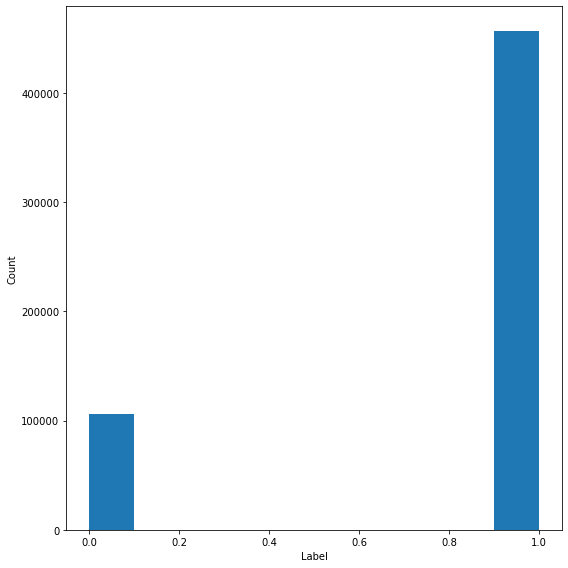

In [18]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [20]:
# create a list of all targets that have at least 20% diversity in one of the output labels
target_name_filter = df.groupby("pref_name").agg({"standard_value_bin": sum, "target_type": "count"}).reset_index(drop=False)
target_name_filter = target_name_filter[target_name_filter["standard_value_bin"] > 0]
target_name_filter["proportion"] = target_name_filter["standard_value_bin"] / target_name_filter["target_type"]
target_name_filter = target_name_filter[(target_name_filter["proportion"] <= 0.8) & (target_name_filter["proportion"] >= 0.2)]

# filter down the dataframe
df = df[df["pref_name"].isin(target_name_filter["pref_name"])]


(array([54448.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 83549.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

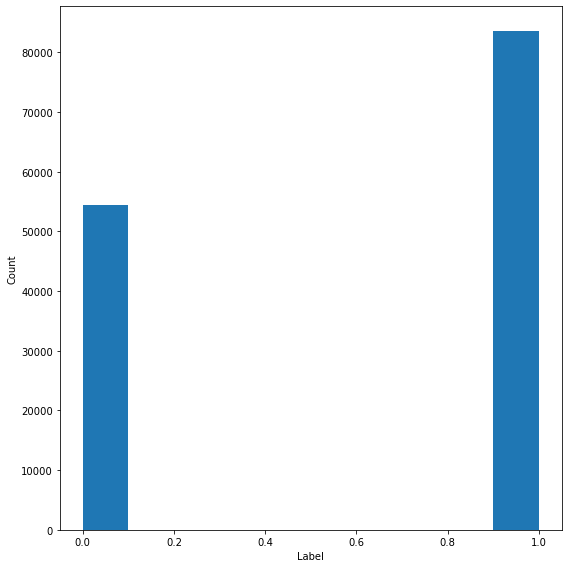

In [21]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [22]:
print("Total Number of Tasks: ", len(df["pref_name"].unique()))

Total Number of Tasks:  927


In [23]:
# determine the assay count by target name
targets = df.groupby("pref_name")[["target_type"]].agg({"target_type": "count"}).sort_values(by="target_type", ascending=False)
targets["cumulative_count"] = targets["target_type"].cumsum()
targets["cumulative_perc"] = targets["cumulative_count"]/sum(targets["target_type"])

# filter down df to top 100 targets
df = df[df["pref_name"].isin(targets.iloc[:30].index)]

In [24]:
print("Record count at the 30th target ", targets.iloc[30]["target_type"])

Record count at the 30th target  895.0


In [25]:
print("Cumulative Record Count in Reduced Dataset: ", targets["cumulative_perc"][30])

Cumulative Record Count in Reduced Dataset:  0.494322340340732


(array([10860.,  3645.,  6678.,  7481., 10396.,  5352.,  6749.,  3780.,
         6466.,  5913.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

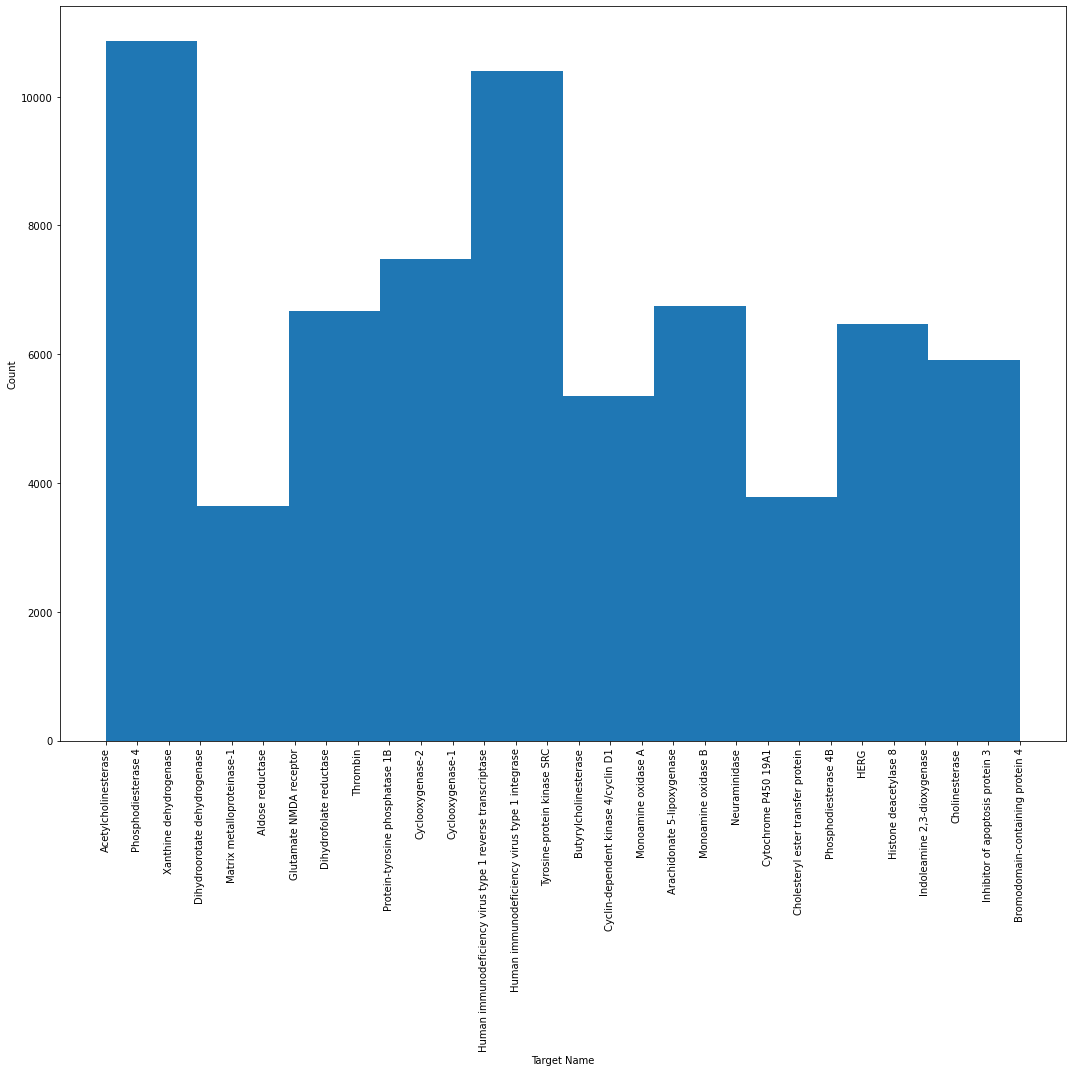

In [26]:
# plot out each set of tasks
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(15)
fig.set_figwidth(15)
axs.set_xlabel("Target Name")
axs.set_ylabel("Count")
plt.xticks(rotation=90)
axs.hist(df["pref_name"])

(array([25370.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41950.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

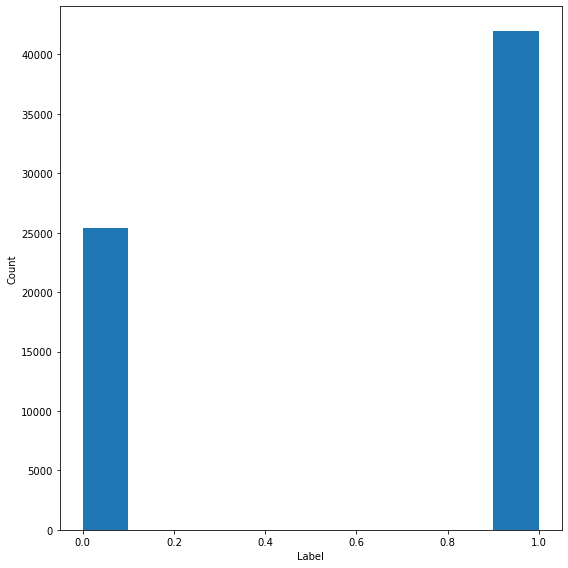

In [27]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [28]:
# Apply the function to each row of the DataFrame
df['Fingerprint'] = df["canonical_smiles"].apply(generate_fingerprint)

In [29]:
# initialize empty list of X and y values
task_X_list = []
task_y_list = []

# for each target, create a list of fingerprint values and associated labels
for target in df["pref_name"].unique():
    X = np.array(df[df["pref_name"] == target]["Fingerprint"].tolist())
    y = df[df["pref_name"] == target]["standard_value_bin"].values

    task_X_list.append((target, X))
    task_y_list.append((target, y))

> Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

Since our dataset has ~65,000 records, we decided to split our data into 80% training, 20% testing. For the generalized model, we need to combine all of the tasks into a single task.  Of the 80% training data, we will perform another split using cross validation (CV).  We CV split the data 5 times, as we keep consistent with the above 80/20 method (5 splits means 4 are training, 1 is testing per iteration - or 80/20).  We use a K-Fold approach because K-Fold allows us to have an even 5-way split, keeping our training and validation data consistent with the above 80/20 rule.  We do not use a stratification approach because we "manually" balanced our classes to a more even class balance.  

For the shared model, we will not CV split the tasks, rather we will use the validation dataset and gather our necessary metrics for comparison through that.  Adding a CV split, especially for tasks with 1,000 records, may be too much splitting to have a meaningful and generalized model.  No stratification is required per task either due to how we handle class balances in the overall dataset.

In [30]:
all_data = {"data": [], "target": [], "data_test": [], "target_test": []}

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x,y in zip(task_X_list, task_y_list):
    X_train[x[0]], X_test[x[0]], y_train[x[0]], y_test[x[0]] = train_test_split(x[1], 
                                                                                y[1], 
                                                                                test_size=0.2, 
                                                                                random_state=7)
    
    all_data["data"].append(X_train[x[0]])
    all_data["target"].append(y_train[x[0]])        
    all_data["data_test"].append(X_test[x[0]])
    all_data["target_test"].append(y_test[x[0]])

X_train_all = np.concatenate(all_data["data"])
y_train_all = np.concatenate(all_data["target"])

X_test_all = np.concatenate(all_data["data_test"])
y_test_all = np.concatenate(all_data["target_test"])

> Train a general model (or per task model) to perform the classification tasks. That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, if this is not possible, you could create a model for each specific task. For a task specific model, each task would be classified with its own feed-forward model.

Our first model approach is to create a general MLP in where we predict each compound structure reaction as non-binding (0) or binding (1).  We opt for a large model structure because we believe that more model parameters and layers will help generalize the model on our 2,048 feature vectors.  In terms of layer design, there is no empirical reason why we start our lower layer at 512 units, however, our philosophy is to decrease layer size for each additional layer by a factor of 2.  We want our layers to approach a smaller number of neurons as the layer count increases because our output is binary.  For activation, we chose ReLU because of the simplicity and our use-case of binary classification fits this activation function well without ghosting the gradients.  Droupout is used as a standard approach to curtail overfitting - previous iterations where we ran with no dropout, we experienced severe overfitting and we found that incorporating 20% dropout in most layers decreased overfitting.  Finally, our last layer has an activation of sigmoid as we found that sigmoid was the best activation for our use case - as opposed to softmax.

For our optimizer, we used ADAM as this is standard and safe to use for binary classification.  Our learning rate, we start at small to curtail above mentioned overfitting.  Our loss function is binary_crossentropy due to the nature of our dataset and labels being binary.  For metrics, we gather precision, accuracy, recall, and AUC for later analysis.

For this section, we will run the model and then elaborate on model analyses.

In [31]:
# initialize model
model = Sequential()

# add input layer plus dropout after first dense layer
model.add(Dense(input_dim=X_train_all.shape[1], units=512, activation='relu', name='input_dense512'))
model.add(Dropout(0.2))

# second layer
model.add(Dense(units=256, activation='relu', name='mid_dense256'))
model.add(Dropout(0.2))

# third layer
model.add(Dense(units=256, activation='relu', name='mid_dense2_216'))
model.add(Dropout(0.2))

# fourth layer
model.add(Dense(units=128, activation='relu', name='mid_dense128'))
model.add(Dropout(0.2))

# fifth layer
model.add(Dense(units=64, activation='relu', name='mid_dense64'))
model.add(Dropout(0.2))

# sixth layer
model.add(Dense(units=32, activation='relu', name='mid_dense32'))
model.add(Dropout(0.2))

# seventh layer
model.add(Dense(units=16, activation='relu', name='mid_dense16'))

# output layer
model.add(Dense(1, activation='sigmoid', name='output_layer'))

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"])



In [39]:
# select cross validation
cv = KFold(n_splits=5)

# initialize empty list of scores
model_scores = []

cv_split = 1

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train_all, y_train_all):
    
    print(f"On Split {cv_split}")

    # split dataset

    X_train_all_cv = X_train_all[train_index]
    y_train_all_cv = y_train_all[train_index]
    X_test_all_cv = X_train_all[test_index]
    y_test_all_cv = y_train_all[test_index]

    # fit the model
    model_history = model.fit(X_train_all_cv, y_train_all_cv, epochs=20, steps_per_epoch=int(len(X_train_all_cv)/32), 
                              shuffle=False, verbose=0, batch_size=32, validation_data=(X_test_all_cv,y_test_all_cv))

    # append scores
    model_scores.append(model_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [ ]:
# calculate the model avg validation precision, recall, and F1
model_avg_val_precision = avg_metric(scores=model_scores, metric="val_precision")
model_avg_val_recall = avg_metric(scores=model_scores, metric="val_recall")
model_f1 = f1_score_calc(precision=model_avg_val_precision, recall=model_avg_val_recall)

# calculate the final split F1
final_split_f1 = f1_score_calc(precision=model_scores[4]["val_precision"], recall=model_scores[4]["val_recall"])


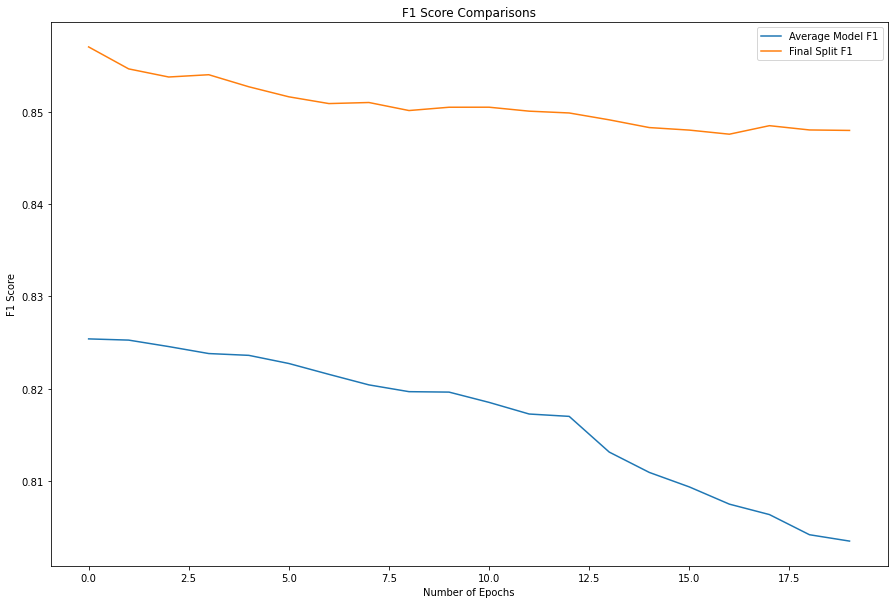

In [ ]:
# plot out all model F1 scores
plt.figure(figsize=(15,10))
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.plot(final_split_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Average Model F1", "Final Split F1"])

Our team observed that this F1 score, although healthy, shows signs of possible overfitting as the trend downwards on both the Average Model F1 and the last CV split F1.  The trend appears to keep going on a downward trend as the number of epochs increase.  This also can mean that our overall model is deteriorating in terms of performance.  Although an argument can be made in performance decline, the same argument can be made that over time (number of splits), performance increased, even if within a split performance slightly decreased (0.87 -> 0.86) over the number of epochs.

The key takeaway: F1 for the latest split of our model performed well but does show signs of overfitting/deterioration.  Supplemental analysis below will paint a fuller picture on model performance.

In [ ]:
# get the average AUC for all models
model_fp, model_tp, model_roc = roc_calc(model, X_test_all, y_test_all)

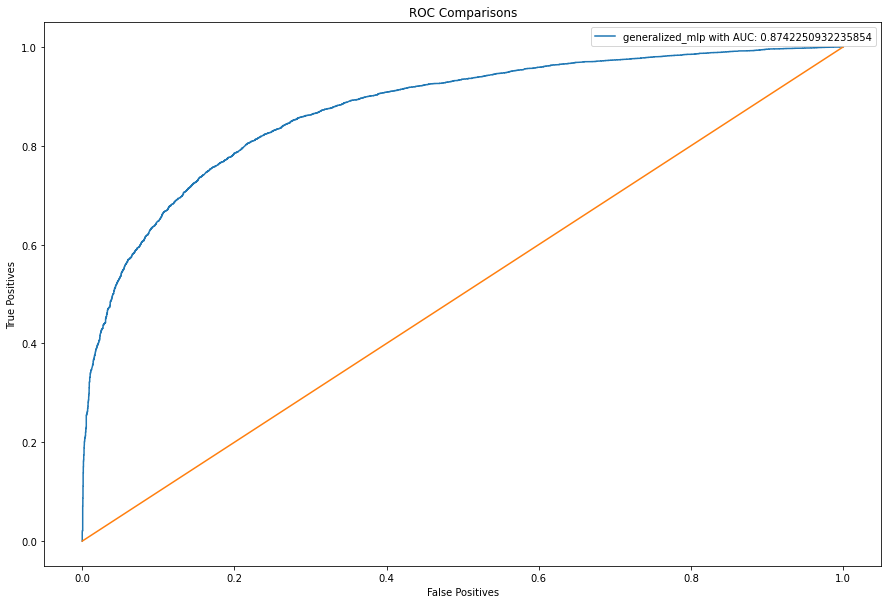

In [ ]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(model_fp, model_tp)
plt.plot([0, 1])
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.legend([f"generalized_mlp with AUC: {model_roc}"])

In the ROC Curve, we see a decently healthy curve that has about an 80% true positive rate for a 20% false positive rate.  The curve elbows off at around 75% to 85% true positive rate - this does not immediately inform us whether our model overfits or not, rather it does paint us a picture that our main evaluation criteria, F1, should be a healthy metric.  This curve indicates a good generalized model for our classification.

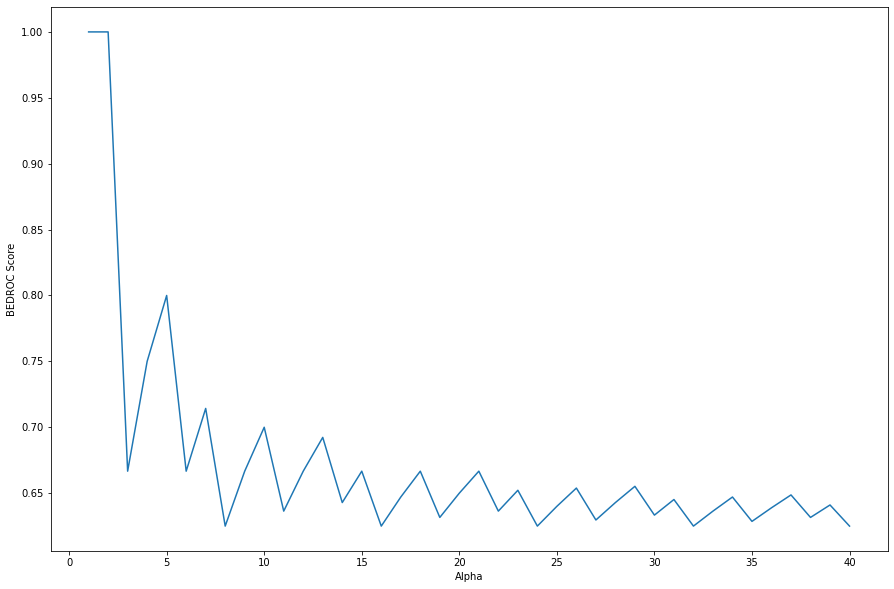

In [ ]:
# predict out y
yhat = model.predict(X_test_all)

# CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
# Generate a range of alpha values
alphas = np.linspace(1, 40, 40)

# Calculate BEDROC scores for each alpha value
bedroc_scores_general = []
for alpha in alphas:
    bedroc_score = bedroc_score_calc(y_true=y_test_all, y_pred=yhat, alpha=alpha)
    bedroc_scores_general.append(bedroc_score)

# Plot BEDROC curve
plt.figure(figsize=(15,10))
plt.plot(alphas, bedroc_scores_general)
plt.xlabel('Alpha')
plt.ylabel('BEDROC Score')
plt.show()

The BEDROC curve is not terrible but also not great.  Generally, if your BEDROC curve is greater than 0.6 at 20 alpha, it's considered passable by industry standards.  However, if the BEDROC fluctuates then this means that the model may be overfitting and that our model is not generalizing the top molecules accurately.  Because no team member is a SME in this field, we take this reading as cautionary rather than dismiss our model entirely.  We still have supporting evidence, per the F1 score, to suggest that our model can correctly generalize without predicting a singular classification.  Additionally, the BEDROC calculation may have errors as this was the team's first attempt at piecing together a BEDROC formula.  Overall, we agree that the BEDROC values at 20 alpha indicate a decently strong model, but that fluctuating trends can cause concern about the validity of classifications.

[0. 0. 0. ... 0. 0. 0.]


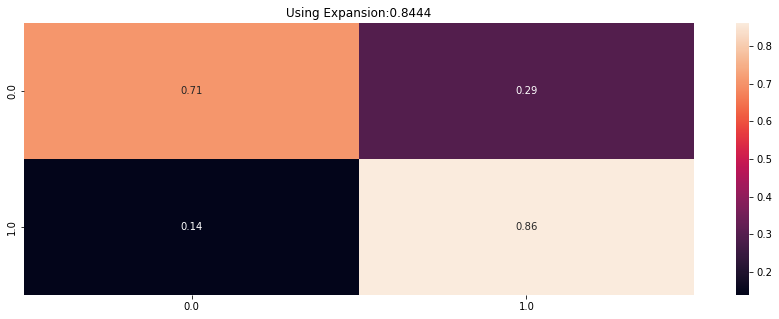

In [ ]:
# summarize the last model to run
summarize_net(model, X_test_all, y_test_all, title_text='Using Expansion:')

In [ ]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(model, X_test_all, y_test_all)

[[3590 1500]
 [1162 7223]]
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      5090
         1.0       0.83      0.86      0.84      8385

    accuracy                           0.80     13475
   macro avg       0.79      0.78      0.79     13475
weighted avg       0.80      0.80      0.80     13475



array([[3590, 1500],
       [1162, 7223]], dtype=int64)

Model 1 Validation F1: 0.8189742076718322
Model 2 Validation F1: 0.7794023575946136
Model 3 Validation F1: 0.8291014693111951
Model 4 Validation F1: 0.7744490370626339
Model 5 Validation F1: 0.8507413718808464
Average Model Validation F1 Score: 0.8105336887042244


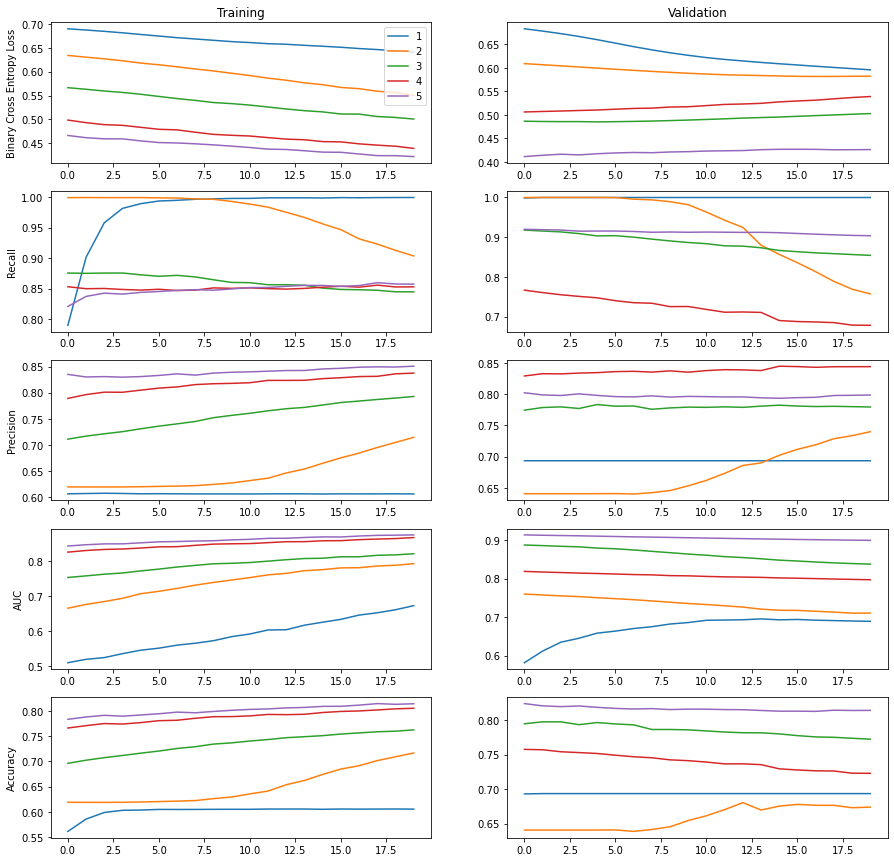

In [ ]:
# plot supporting metrics
plot_metrics(model_scores)

The above 3 panels show additional supporting metrics that support our F1 scores above.  The confusion matrix shows that our model is not picking a single class to classify on and that there is a healthy spread of generalizations.  Model metrics such as Loss and Accuracy show that the risk of overfitting appears limited - as validation sets are decreasing with loss and increasing with accuracy for each split by each epoch.

> Train a multi-task model (and/or) multi-modal model. You may use any method of multi-task or multi-modal training that you like.  For multi-task models, some fine tuning of the model should be attempted. For multi-modal models, some investigation of "where to merge" the modalities should be attempted. Be sure to look at the class demonstration example for code and hints. Feel free to use this code as a starting template.

For our multi-task model, we begin by extracting the weights from our generalized model.  Because these weights are pre-trained, we set these weights to non-trainable.  Next, we assign each of these weights to their respective layers in the new shared MLP model.  To keep things consistent, we design the same model structure with the same number of neurons per layer, the same number of layers, and the same activations per layer.  Finally, we construct our model while ensuring that no layers are trainable other than the final layer.  We do not add dropout.  We find this distinction important.  The dropout within the first model persists into the weights of this new model as the first model trained with dropout.  Therefore, we believe that weights trained in the first model take dropout into consideration.

The train and test sets must be resplit to adhere to our 80/20 rule defined above.  Before running the epochs we split the dataset. We suspect that loss will not change drastically between epochs and will be similar to the generalized model because both models are similar.

In [ ]:
# create keys dictionary
X_keys = dict()
X_keys.update(X_train)
X_keys.update(X_test)

In [ ]:
#get weights of generalized model
w1 = model.get_layer('input_dense512').get_weights()
w2 = model.get_layer('mid_dense256').get_weights()
w3 = model.get_layer('mid_dense2_216').get_weights()
w4 = model.get_layer('mid_dense128').get_weights()
w5 = model.get_layer('mid_dense64').get_weights()
w6 = model.get_layer('mid_dense32').get_weights()
w7 = model.get_layer('mid_dense16').get_weights()
w_output = model.get_layer('output_layer').get_weights()

# set these weights
inputs = Input(shape=(X_train_all.shape[1],))
shared_input = Dense(512, activation='relu', name = 'shared_input', trainable=False)(inputs)
shared_mlp_1 = Dense(256, activation='relu', name = 'shared_middle1', trainable=False)(shared_input)
shared_mlp_2 = Dense(256, activation='relu', name = 'shared_middle2', trainable=False)(shared_mlp_1)
shared_mlp_3 = Dense(128, activation='relu', name = 'shared_middle3', trainable=False)(shared_mlp_2)
shared_mlp_4 = Dense(64, activation='relu', name = 'shared_middle4', trainable=False)(shared_mlp_3)
shared_mlp_5 = Dense(32, activation='relu', name = 'shared_middle5', trainable=False)(shared_mlp_4)
shared_mlp_6 = Dense(16, activation='relu', name = 'shared_middle6', trainable=False)(shared_mlp_5)

# make a dictionary of models for each task
models_mtl = dict()

for x in X_keys.keys():
    # use same architecture as the general model, but 
    #. repeat the output layer for each school  
    output_layer = Dense(1, activation='sigmoid')(shared_mlp_6)
    model_task = Model(inputs=inputs, outputs=output_layer)

    models_mtl[x] = model_task

    shared1 = models_mtl[x].get_layer('shared_input')
    shared2 = models_mtl[x].get_layer('shared_middle1')
    shared3 = models_mtl[x].get_layer('shared_middle2')
    shared4 = models_mtl[x].get_layer('shared_middle3')
    shared5 = models_mtl[x].get_layer('shared_middle4')
    shared6 = models_mtl[x].get_layer('shared_middle5')
    shared7 = models_mtl[x].get_layer('shared_middle6')
    personal = models_mtl[x].layers[-1]
    
    # set to be the weights from the general model, as starting point
    shared1.set_weights(w1)
    shared2.set_weights(w2)
    shared3.set_weights(w3)
    shared4.set_weights(w4)
    shared5.set_weights(w5)
    shared6.set_weights(w6)
    shared7.set_weights(w7)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    shared3.trainable = False
    shared4.trainable = False
    shared5.trainable = False
    shared6.trainable = False
    shared7.trainable = False
    personal.trainable = True

In [ ]:
%%time
EPOCHS = 20
total_cfm_f1_by_epoch = []

opt = {} # need separate optimizers for each output task
for x in X_keys.keys():
    
    opt[x] = Adam() # track 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
   # shuffle(all_keys) # shuffle in place operation, maybe not needed
    
    step(X_keys.keys(), opt, X_train, y_train) # batched gradient updates
    
    y_mtl=[]
    yhat_mtl=[]
    cfm_agg = []

    for x in X_keys.keys():
        # test on data, for tracking
        yhat_mlp = models_mtl[x].predict(X_test[x],verbose=0)
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        yhat_mlp_copy = yhat_mlp.copy()
        yhat_mlp_copy[yhat_mlp_copy<0.5] = 0 
        yhat_mlp_copy[yhat_mlp_copy>=0.5] = 1
        cfm = mt.confusion_matrix(y_test[x],yhat_mlp_copy).ravel()
        cfm_agg.append(cfm)

    # sum total confusion matrix (tn, fp, fn, tp)
    total_cfm = sum(cfm_agg)

    total_cfm_precision = precision_calc(total_cfm[3], total_cfm[1])
    total_cfm_recall = recall_calc(total_cfm[3], total_cfm[2])
    total_cfm_f1 = f1_score_calc(total_cfm_precision, total_cfm_recall)
    total_cfm_f1_by_epoch.append(total_cfm_f1)
    
    bce = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl)) #this should probably be bce or f1, not mse, just using for now
    print('...Binary Cross Entropy:',bce.numpy())

Epoch 0, ...Binary Cross Entropy: 0.4348739
Epoch 1, ...Binary Cross Entropy: 0.4344753
Epoch 2, ...Binary Cross Entropy: 0.43408117
Epoch 3, ...Binary Cross Entropy: 0.4336913
Epoch 4, ...Binary Cross Entropy: 0.43330568
Epoch 5, ...Binary Cross Entropy: 0.43292397
Epoch 6, ...Binary Cross Entropy: 0.43254608
Epoch 7, ...Binary Cross Entropy: 0.4321719
Epoch 8, ...Binary Cross Entropy: 0.43180147
Epoch 9, ...Binary Cross Entropy: 0.43143472
Epoch 10, ...Binary Cross Entropy: 0.43107188
Epoch 11, ...Binary Cross Entropy: 0.4307131
Epoch 12, ...Binary Cross Entropy: 0.43035844
Epoch 13, ...Binary Cross Entropy: 0.4300081
Epoch 14, ...Binary Cross Entropy: 0.42966226
Epoch 15, ...Binary Cross Entropy: 0.4293209
Epoch 16, ...Binary Cross Entropy: 0.42898417
Epoch 17, ...Binary Cross Entropy: 0.42865202
Epoch 18, ...Binary Cross Entropy: 0.42832452
Epoch 19, ...Binary Cross Entropy: 0.4280015
Wall time: 43.3 s


> Report the results using the evaluation procedure that you argued for at the beginning of the lab. Compare the general/personal model to your best multi-modal/multi-task model. Results should be reported with proper statistical comparisons and proper visualizations.

We will have two main comparisons: F1 for model performance and McNemar for statistical differences.  We will support the F1 analysis with a BEDROC analysis and confusion matrix - but note that it is challenging to aggregate metrics from the task level as each task size is different.  Therefore, we want to stress that F1 is a shared metric between both models for comparison, but BEDROC and any additional model metrics are dependent on the task level and can not be aggregated cleanly.

Analysis will be done per section as defined above

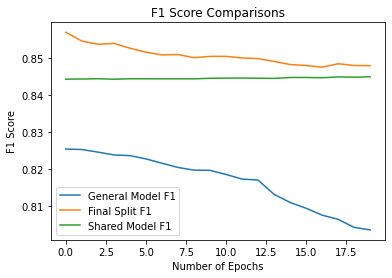

In [ ]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.plot(final_split_f1)
plt.plot(total_cfm_f1_by_epoch)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["General Model F1", "Final Split F1", "Shared Model F1"])

This F1 score, like the general model, appears healthy but also shows signs of possible overfitting but not to the same degree as the general model - indicated by the steadiness in F1 score of the shared model (green).  The F1 for this shared model does indicate that the shared model performance is better than the overall general model performance, but with the caveat of potential overfitting, much like the general.  This isn't shocking because our model architecture is identical to the general model and the weights are exactly the same with no trainable layers.  The only difference is the learning rate where the general model has a learning rate of 1e-6 and the shared model has a default learning rate of 1e-3.  The final split general model performs better than the shared model, but only slightly.  The only notable difference other than performance is the apparent lack of evidence of overfitting for the shared model, which appears more evident in the final split general model.  

The key takeaway: F1 for the shared model indicates an outperformance compared to the overall general model.  It is slightly outperformed by the final split model but shows little signs of overfitting.

In [ ]:
bedroc_scores_mtl = {}

# CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
# Generate a range of alpha values
alphas = np.linspace(1, 40, num=40)

# Calculate BEDROC scores for each alpha value
bedroc_scores = []
for alpha in alphas:
    bedroc_score = bedroc_score_calc(y_true=np.concatenate(y_mtl), y_pred=np.concatenate(yhat_mtl), alpha=alpha)
    bedroc_scores.append(bedroc_score)

bedroc_scores_mtl = bedroc_scores

# convert bedroc scores into a dataframe
bedroc_scores_mtl_df = pd.DataFrame(bedroc_scores_mtl)

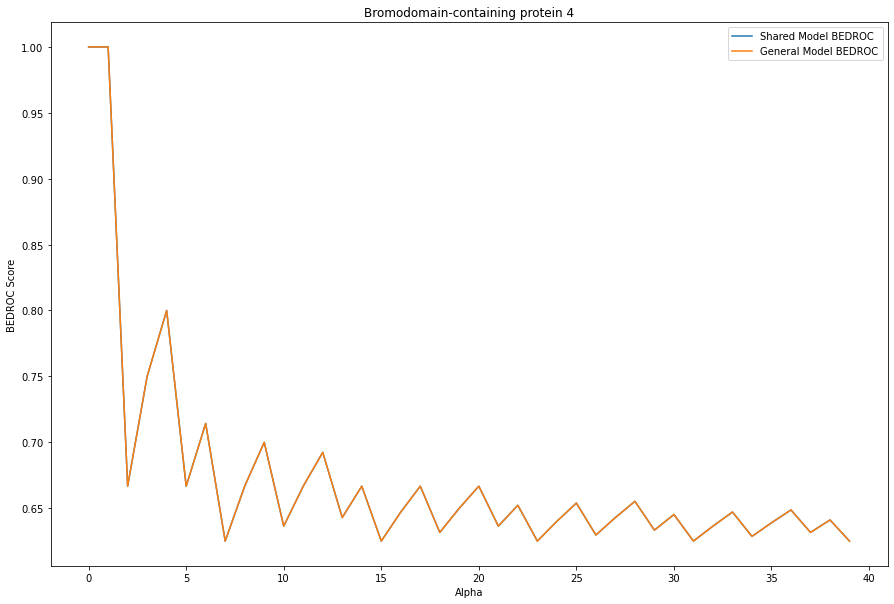

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(bedroc_scores_mtl_df)
plt.plot(bedroc_scores)
plt.xlabel('Alpha')
plt.ylabel('BEDROC Score')
plt.title(target)
plt.legend(["Shared Model BEDROC", "General Model BEDROC"])

The BEDROC curve for the shared model overlays on top of the general model indicating that both models struggle in generalizing the top molecule reactions accurately.  Once again, similar to F1, this isn't surprising for us as the shared model and general model are nearly identical.  Like the general model, our BEDROC score at 20 alpha is above 0.6 indicating a decent performance but not optimal.  Further, fluctuations cause us to question how much our model overfits.  Our F1 score still indicates that our model can correctly generalize, but like our general model we heed caution as the BEDROC scores provide evidence to the contrary.

<AxesSubplot:>

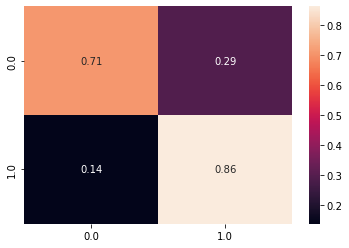

In [ ]:
# plot confusion matrix
total_cfm_perc = total_cfm.reshape(2,2)
total_cfm_perc = total_cfm_perc/np.sum(total_cfm_perc,axis=1)[:,np.newaxis]
sns.heatmap(total_cfm_perc, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))

We end this shared model analysis with a confusion matrix to enforce our F1 analysis above.  There is a decent spread of true positives and true negatives, however this matrix is almost identical to the general model, but that is expected due to described model architecture and weights in the above analysis.

Our next step is to fine tune this model.  For fine tuning, our team spent a considerable amount of time to try different combinations of trainable layers and learning rates (not shown), but most combinations yielded the same losses and F1 scores.  The below model was decided after extensive testing on various combinations.

In [ ]:
%%time
EPOCHS = 20
total_cfm_f1_by_epoch_model2 = []

opt = {} # need separate optimizers for each output task
for x in X_keys.keys():

    # fine tune model
    shared1 = models_mtl[x].get_layer('shared_input')
    shared2 = models_mtl[x].get_layer('shared_middle1')
    shared3 = models_mtl[x].get_layer('shared_middle2')
    shared4 = models_mtl[x].get_layer('shared_middle3')
    shared5 = models_mtl[x].get_layer('shared_middle4')
    shared6 = models_mtl[x].get_layer('shared_middle5')
    shared7 = models_mtl[x].get_layer('shared_middle6')

    shared1.trainable = True
    shared2.trainable = False
    shared3.trainable = False
    shared4.trainable = True
    shared5.trainable = False
    shared6.trainable = False
    shared7.trainable = True
    
    opt[x] = Adam(learning_rate=1e-6) # track 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
   # shuffle(all_keys) # shuffle in place operation, maybe not needed
    
    step(X_keys.keys(), opt, X_train, y_train) # batched gradient updates
    
    y_mtl=[]
    yhat_mtl=[]
    cfm_agg = []

    for x in X_keys.keys():
        # test on data, for tracking
        yhat_mlp = models_mtl[x].predict(X_test[x],verbose=0)
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        yhat_mlp_copy = yhat_mlp.copy()
        yhat_mlp_copy[yhat_mlp_copy<0.5] = 0 
        yhat_mlp_copy[yhat_mlp_copy>=0.5] = 1
        cfm = mt.confusion_matrix(y_test[x],yhat_mlp_copy).ravel()
        cfm_agg.append(cfm)

    # sum total confusion matrix (tn, fp, fn, tp)
    total_cfm = sum(cfm_agg)

    total_cfm_precision = precision_calc(total_cfm[3], total_cfm[1])
    total_cfm_recall = recall_calc(total_cfm[3], total_cfm[2])
    total_cfm_f1 = f1_score_calc(total_cfm_precision, total_cfm_recall)
    total_cfm_f1_by_epoch_model2.append(total_cfm_f1)
    
    bce = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl)) #this should probably be bce or f1, not mse, just using for now
    print('...Binary Cross Entropy:',bce.numpy())

Epoch 0, ...Binary Cross Entropy: 0.42455631
Epoch 1, ...Binary Cross Entropy: 0.42448515
Epoch 2, ...Binary Cross Entropy: 0.42441437
Epoch 3, ...Binary Cross Entropy: 0.42434394
Epoch 4, ...Binary Cross Entropy: 0.42427346
Epoch 5, ...Binary Cross Entropy: 0.42420396
Epoch 6, ...Binary Cross Entropy: 0.42413563
Epoch 7, ...Binary Cross Entropy: 0.42406794
Epoch 8, ...Binary Cross Entropy: 0.42400068
Epoch 9, ...Binary Cross Entropy: 0.4239344
Epoch 10, ...Binary Cross Entropy: 0.42386892
Epoch 11, ...Binary Cross Entropy: 0.423804
Epoch 12, ...Binary Cross Entropy: 0.42373914
Epoch 13, ...Binary Cross Entropy: 0.42367455
Epoch 14, ...Binary Cross Entropy: 0.4236101
Epoch 15, ...Binary Cross Entropy: 0.4235455
Epoch 16, ...Binary Cross Entropy: 0.42348164
Epoch 17, ...Binary Cross Entropy: 0.42341763
Epoch 18, ...Binary Cross Entropy: 0.42335364
Epoch 19, ...Binary Cross Entropy: 0.42328936
Wall time: 45.6 s


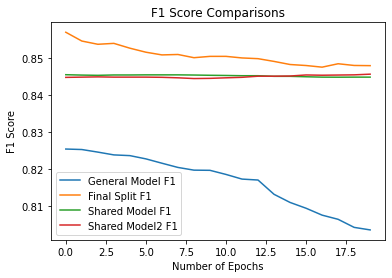

In [ ]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.plot(final_split_f1)
plt.plot(total_cfm_f1_by_epoch)
plt.plot(total_cfm_f1_by_epoch_model2)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["General Model F1", "Final Split F1", "Shared Model F1", "Shared Model2 F1"])

There isn't much difference between this analysis and the first analysis for the shared model.  Both shared models perform similarly to the point where we are making a statiscal assumption that neither are significantly different.  Compared to the general model, both outperform.  Like above, the Final Split general model does outperform, but slightly - and once again with evidence of overfitting.

In [ ]:
bedroc_scores_mtl = {}

# CHATGPT CODE AS PART OF BEDROC_SCORE_CALC FUNCTION
# Generate a range of alpha values
alphas = np.linspace(1, 40, num=40)

# Calculate BEDROC scores for each alpha value
bedroc_scores = []
for alpha in alphas:
    bedroc_score = bedroc_score_calc(y_true=np.concatenate(y_mtl), y_pred=np.concatenate(yhat_mtl), alpha=alpha)
    bedroc_scores.append(bedroc_score)

bedroc_scores_mtl = bedroc_scores

# convert bedroc scores into a dataframe
bedroc_scores_mtl_df = pd.DataFrame(bedroc_scores_mtl)

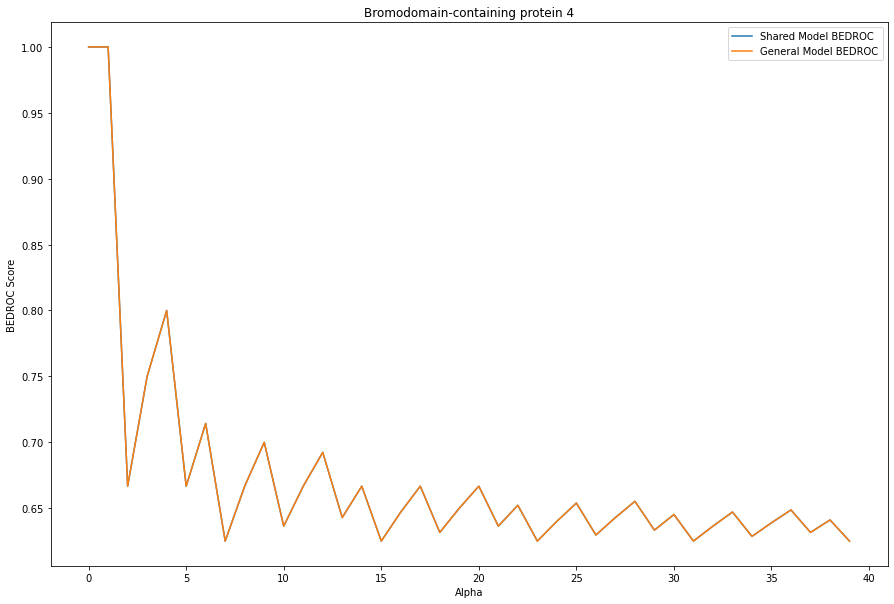

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(bedroc_scores_mtl_df)
plt.plot(bedroc_scores)
plt.xlabel('Alpha')
plt.ylabel('BEDROC Score')
plt.title(target)
plt.legend(["Shared Model BEDROC", "General Model BEDROC"])

The BEDROC curve for the updated shared model overlays on top of the general model.  This analysis is the same as done in the shared model vs general model.  We don't think there is much more room for commentary.  This gives us evidence to suggest that both models are nearly identical, even when fine-tuning the shared model.  Further, this gives us evidence that this particular excercise does not require a multi-task solution, although slight overfitting in the general model can make an argument against this assertion.

<AxesSubplot:>

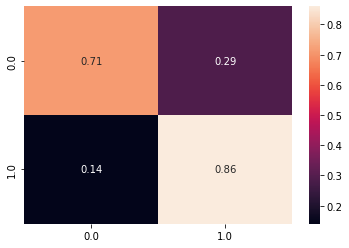

In [ ]:
# plot confusion matrix
total_cfm_perc = total_cfm.reshape(2,2)
total_cfm_perc = total_cfm_perc/np.sum(total_cfm_perc,axis=1)[:,np.newaxis]
sns.heatmap(total_cfm_perc, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))

In [ ]:
# create our confusion matrices
general_model_cfm = plot_cf_matrix(model, X_test_all, y_test_all).ravel()
shared_model_cfm = total_cfm.copy()

# calculate the mcnemar test
mcnemar_test(general_model_cfm, shared_model_cfm)


[[3590 1500]
 [1162 7223]]
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      5090
         1.0       0.83      0.86      0.84      8385

    accuracy                           0.80     13475
   macro avg       0.79      0.78      0.79     13475
weighted avg       0.80      0.80      0.80     13475

McNemar's test statistic: 0.000
p-value: 1.000


The confusion matrix supports our F1 score analysis.  It is not surprising that all confusion matrices across models share similar distributions.  Another piece of evidence to suggest that how we conducted this exercise and the use case involved does not necessarily require multi-tasking.

In terms of statistical significance and with a p-value of 1, we are 100% certain there is no significance between either models (fine tuned shared vs general) and that both models are predicting the same outcomes and are generalizing on the same classifications.  McNemar's test statistic of 0 supports this.

>Finally, you have freedom to perform any other analysis you want. Please explain what analysis you are investigating and why.
>
>    - One idea, multi-modal: Try to perform classification into a shared latent space among all input modalities. That is, each modality will map into the same shared latent space. If one modality was not available, then the classification could still be performed. Multiple modalities could also be used. 
>    - Another idea, multi-task: Try to perform multi-task classification by adding a self-supervised auxiliary task (or consistency loss).

For our analysis, we decided to expand the underlying dataset to include target names that had severe class imbalances.  We wanted to see if the trained model weights would be able to classify on targets with imbalanced classes.  We take the general MLP model weights and construct a model where we classify the target activation (binary).  We one-hot encode our y labels and our features are the same as the first model (fingerprints).  We predict on a larger dataset and not the subset that we did above in our first binary classification.  The number of targets increased to 50, and the size of our new dataset is 168,000, or about 2.5x the original dataset.  We rationalize that this is acceptable for this exercise as this is more experimental than practical.  The intended use of this exercise is to see if model knowledge can extend to other not seen domain targets.

We don't change any part of our model, but we freeze the weights in place.  The model architecture and learning rate will be identical otherwise.

In [61]:
# read in data
df_aux = pd.read_csv("chemBL.csv")

In [62]:
# binarize ligand values based on ranges <=300 nM and >=10000 nM (1 for active, 0 for inactive respectively)
df_aux.loc[df_aux["standard_value"] <= 300.0, "standard_value_bin"] = 1
df_aux.loc[df_aux["standard_value"] >= 10000.0, "standard_value_bin"] = 0

In [65]:
# determine the assay count by target name
targets = df_aux.groupby("pref_name")[["target_type"]].agg({"target_type": "count"}).sort_values(by="target_type", ascending=False)
targets["cumulative_count"] = targets["target_type"].cumsum()
targets["cumulative_perc"] = targets["cumulative_count"]/sum(targets["target_type"])

# filter down df to top 100 targets
df_aux = df_aux[df_aux["pref_name"].isin(targets.iloc[:50].index)]

In [68]:
# Apply the function to each row of the DataFrame
df_aux['Fingerprint'] = df_aux["canonical_smiles"].apply(generate_fingerprint)

In [76]:
# create X and y datasets
y_aux = df_aux["standard_value_bin"].copy()
X_aux = df_aux["Fingerprint"].copy()
X_aux = np.array(X_aux.tolist())
y_aux = np.array(y_aux.tolist())

In [77]:
# train test split X, y
X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(X_aux, y_aux, test_size=0.2, random_state=7)

In [78]:
#get weights of generalized model
w1_aux = model.get_layer('input_dense512').get_weights()
w2_aux = model.get_layer('mid_dense256').get_weights()
w3_aux = model.get_layer('mid_dense2_216').get_weights()
w4_aux = model.get_layer('mid_dense128').get_weights()
w5_aux = model.get_layer('mid_dense64').get_weights()
w6_aux = model.get_layer('mid_dense32').get_weights()
w7_aux = model.get_layer('mid_dense16').get_weights()
w_output_aux = model.get_layer('output_layer').get_weights()

# set these weights
inputs_aux = Input(shape=(X_train_aux.shape[1],))
shared_input_aux = Dense(512, activation='relu', name = 'shared_input', trainable=False)(inputs_aux)
shared_mlp_1_aux = Dense(256, activation='relu', name = 'shared_middle1', trainable=False)(shared_input_aux)
shared_mlp_2_aux = Dense(256, activation='relu', name = 'shared_middle2', trainable=False)(shared_mlp_1_aux)
shared_mlp_3_aux = Dense(128, activation='relu', name = 'shared_middle3', trainable=False)(shared_mlp_2_aux)
shared_mlp_4_aux = Dense(64, activation='relu', name = 'shared_middle4', trainable=False)(shared_mlp_3_aux)
shared_mlp_5_aux = Dense(32, activation='relu', name = 'shared_middle5', trainable=False)(shared_mlp_4_aux)
shared_mlp_6_aux = Dense(16, activation='relu', name = 'shared_middle6', trainable=True)(shared_mlp_5_aux)


# use same architecture as the general model, but 
# repeat the output layer for each school  
output_layer_aux = Dense(1, activation='sigmoid')(shared_mlp_6_aux)
model_task_aux = Model(inputs=inputs_aux, outputs=output_layer_aux)

shared1_aux = model_task_aux.get_layer('shared_input')
shared2_aux = model_task_aux.get_layer('shared_middle1')
shared3_aux = model_task_aux.get_layer('shared_middle2')
shared4_aux = model_task_aux.get_layer('shared_middle3')
shared5_aux = model_task_aux.get_layer('shared_middle4')
shared6_aux = model_task_aux.get_layer('shared_middle5')
shared7_aux = model_task_aux.get_layer('shared_middle6')
personal_aux = model_task_aux.layers[-1]

# set to be the weights from the general model, as starting point
shared1_aux.set_weights(w1_aux)
shared2_aux.set_weights(w2_aux)
shared3_aux.set_weights(w3_aux)
shared4_aux.set_weights(w4_aux)
shared5_aux.set_weights(w5_aux)
shared6_aux.set_weights(w6_aux)
shared7_aux.set_weights(w7_aux)
personal_aux.set_weights(w_output_aux)
shared1_aux.trainable = False
shared2_aux.trainable = False
shared3_aux.trainable = False
shared4_aux.trainable = False
shared5_aux.trainable = False
shared6_aux.trainable = False
shared7_aux.trainable = False
personal_aux.trainable = True

In [79]:
# select cross validation
cv = KFold(n_splits=5)

# initialize empty list of scores
model_aux_scores = []

cv_split = 1

# compile model
model_task_aux.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"])

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train_aux, y_train_aux):
    
    print(f"On Split {cv_split}")

    # split dataset

    X_train_aux_cv = X_train_aux[train_index]
    y_train_aux_cv = y_train_aux[train_index]
    X_test_aux_cv = X_train_aux[test_index]
    y_test_aux_cv = y_train_aux[test_index]

    # fit the model
    model_task_aux_history = model_task_aux.fit(X_train_aux, y_train_aux, epochs=20, steps_per_epoch=int(len(X_train_aux)/32), 
                              shuffle=False, verbose=0, batch_size=32, validation_data=(X_test_aux,y_test_aux))

    # append scores
    model_aux_scores.append(model_task_aux_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [87]:
# calculate the model avg validation precision, recall, and F1
model_aux_avg_val_precision = avg_metric(scores=model_aux_scores, metric="val_precision")
model_aux_avg_val_recall = avg_metric(scores=model_aux_scores, metric="val_recall")
model_aux_f1 = f1_score_calc(precision=model_aux_avg_val_precision, recall=model_aux_avg_val_recall)

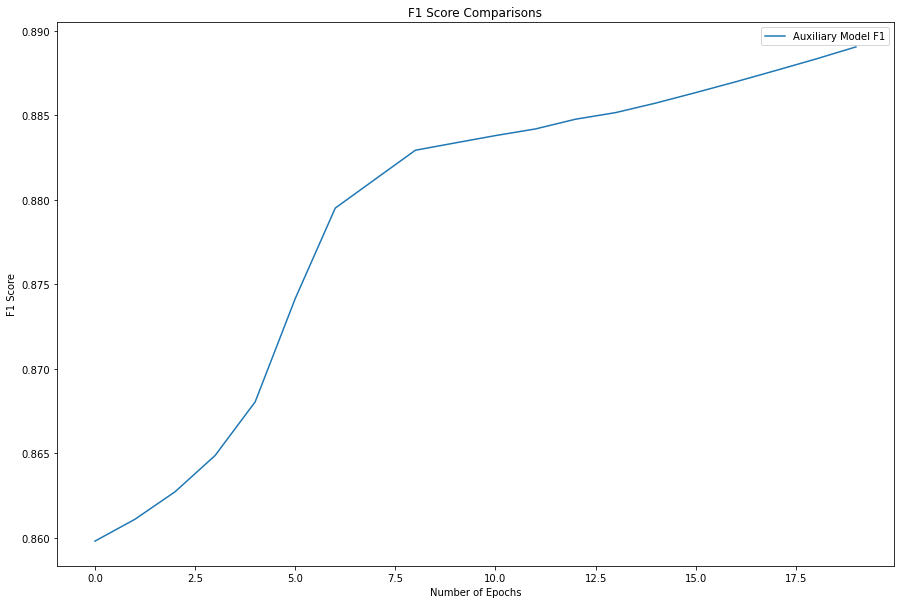

In [88]:
# plot out all model F1 scores
plt.figure(figsize=(15,10))
plt.title('F1 Score Comparisons')
plt.plot(model_aux_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Auxiliary Model F1"])

Model 1 Validation F1: 0.7774706780139763
Model 2 Validation F1: 0.8059921368198633
Model 3 Validation F1: 0.9096403094564106
Model 4 Validation F1: 0.9281264601549383
Model 5 Validation F1: 0.9281264601549383
Average Model Validation F1 Score: 0.8698712089200253


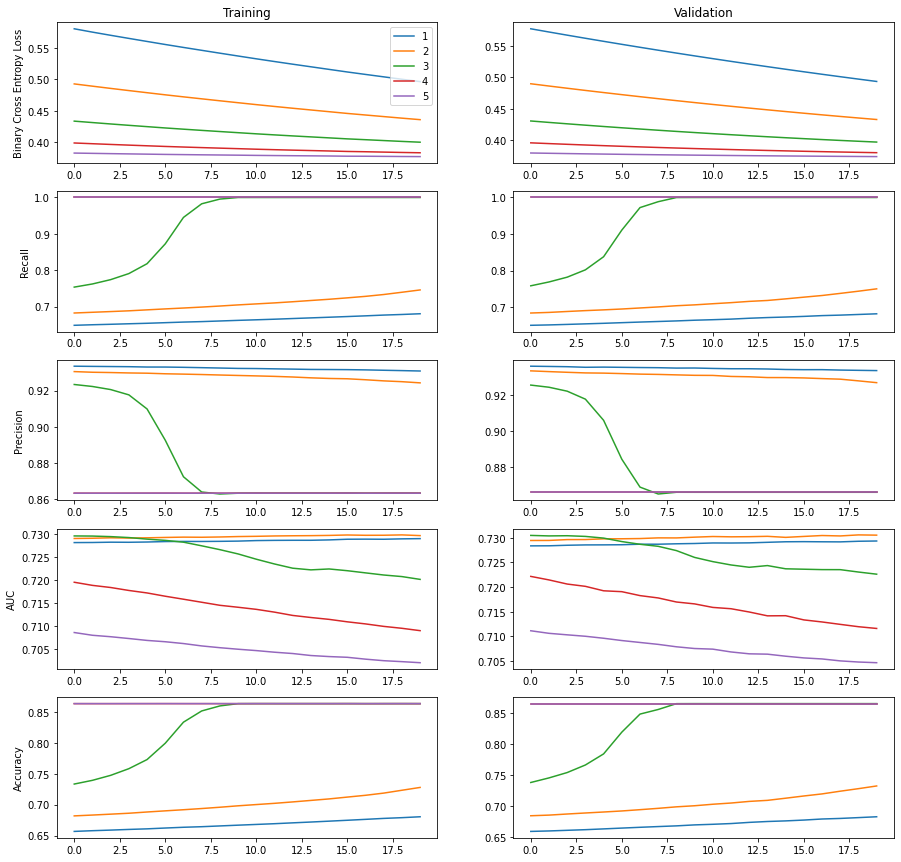

In [89]:
plot_metrics(model_aux_scores)

In [90]:
# get the average AUC for all models
model_aux_fp, model_aux_tp, model_aux_roc = roc_calc(model_task_aux, X_test_aux, y_test_aux)

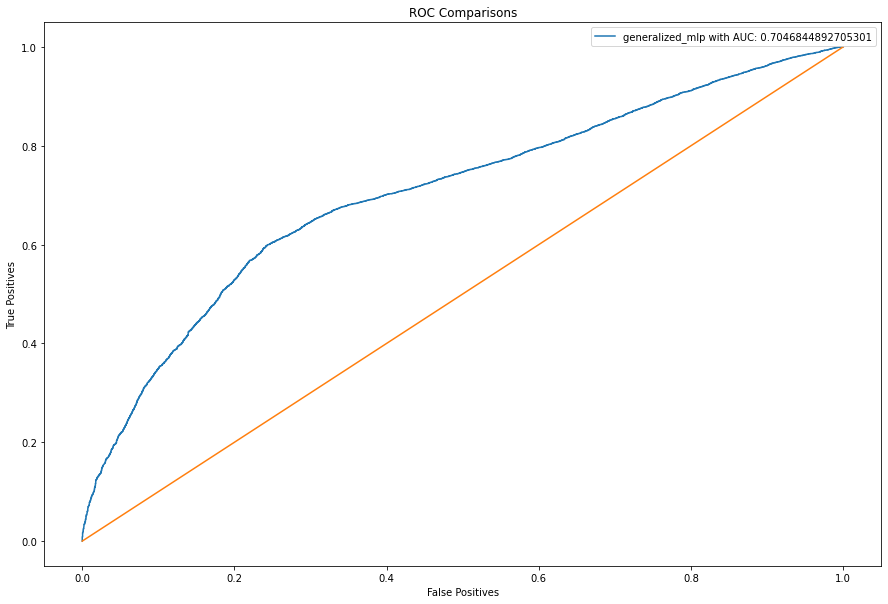

In [91]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(model_aux_fp, model_aux_tp)
plt.plot([0, 1])
plt.ylabel('True Positives')
plt.xlabel('False Positives')
plt.legend([f"generalized_mlp with AUC: {model_aux_roc}"])

[]


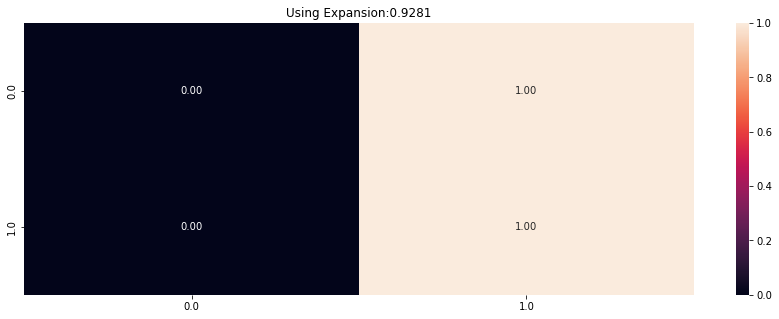

In [92]:
# summarize the last model to run
summarize_net(model_task_aux, X_test_aux, y_test_aux, title_text='Using Expansion:')

Although we had hopes that we could "transfer" the learning of our previous model into a data domain unseen, it appears that the model overfit the data to the point where only the 1 class is being predicted (activated).  The model metrics such as F1 appear good and at first glance provide evidence that the model is able to train and test on new data, however the confusion matrix reveals this not to be the case.  Our general concensus: the initial binary classification model was able to generalize well, but when extrapolating to a dataset that contains class imbalances does not generalize well.

## Final Analysis

To set out on our analysis into ChemBL, we had to prune our dataset down to a set of tasks that had an adequate amount of class balances.  Additionally, we found that overfitting started to occur within the generalized model - but appeared to subside when look at the multi-task model.  F1 scores provide good evidence that the model classifies and performs well, but the BEDROC scores caution us as to whether this model would be a practical and industrialized tool for drug makers.  Further, our additional analysis provided evidence that expanding our dataset to include targets with class imbalances disturbs the models ability to classify correctly.  This indicates that the model trained would require more diverse data.